# P-Center Problem

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

Hakimi (1964) introduced the absolute center problem to locate a police station or a hospital such that the maximum distance of the station to a set of communities connected by a highway system is minimized. Hakimi (1965) generalizes the absolute center problem to the $p$-center problem. Given a set $X_p=\{x_1,\ldots,x_p\}$ of $p$ points in graph $G$, the distance $d(X_p, v_j)$ between $X_p$ and node $v_j$ is computed as $\min_{i=1,\ldots,n}{w_jd(v_j, X_p)}$. Daskin (2013) proposed a Mixed Integer Programming formulation to discretize the $p$-center problem written as:

$\begin{array} \displaystyle \textbf{Minimize} & W && (1)\\
\displaystyle \textbf{Subject to:} & \sum_{j}{X_{ij} = 1} & \forall i & (2) \\
            & \sum_{j}{Y_{j} = p} && (3) \\
            & X_{ij} \leq Y_{j} & \forall i,j & (4) \\
            & W \geq \sum_{j}{d_{ij}X_{ij}} & \forall i & (5)\\
            & Y_{j} \in \{0,1\} & \forall j & (6) \\ 
            & X_{ij} \geq 0 & \forall i,j & (7)\\
            \end{array}$

$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing nodes of the network as demand} \\
& & j & \small = & \textrm{index referencing nodes of the network as potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes } i \textrm{ and } j \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & Y_j & \small = & \begin{cases} 
          1, \text{if locate at candidate site } j \\
          0, \text{otherwise} \\
       \end{cases} \\
& & X_{ij} & \small = & \textrm{fraction of demand at node } i \textrm{ that is served by a facility at node } j \\
& & W & \small = & \textrm{maximum distance between a demand node and the nearest facility} \\
\end{array}$

This tutorial generates synthetic demand (clients) and facility sites near a 10x10 lattice representing a gridded urban core. Three $p$-center instances are solved while varying parameters:
* `PCenter.from_cost_matrix()` with network distance as the metric
* `PCenter.from_geodataframe()` with euclidean distance as the metric
* `PCenter.from_geodataframe()` with predefined facility locations and euclidean distance as the metric

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-31T14:36:03.380081-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 22.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy
import pulp
import shapely
import spopt
from spopt.locate import PCenter, simulated_geo_points 

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import spaghetti

%watermark -w
%watermark -iv

Watermark: 2.3.1

numpy     : 1.23.3
shapely   : 1.8.5
matplotlib: 3.6.1
spaghetti : 1.6.7
json      : 2.0.9
pulp      : 2.6.0
spopt     : 0.4.1+200.g336f235.dirty
geopandas : 0.11.1



Since the model needs a cost matrix (distance, time, etc.) we should define some variables. First we will assign some the number of clients and facility locations, then the maximum service radius, followed by random seeds in order to reproduce the results. Finally, the solver, assigned below as `pulp.COIN_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface, such as Gurobi or CPLEX, see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
# quantity demand points
CLIENT_COUNT = 100

# quantity supply points
FACILITY_COUNT = 10

# number of candidate facilities in optimal solution
P_FACILITIES = 3

# random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

# set the solver
solver = pulp.COIN_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create a 10x10 lattice with 9 interior lines, both vertical and horizontal.

In [4]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform the `spaghetti` instance into a geodataframe.

In [5]:
streets = spaghetti.element_as_gdf(ntw, arcs=True)

In [6]:
streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)

Plotting the network created by `spaghetti` we can verify that it mimics a district with quarters and streets.

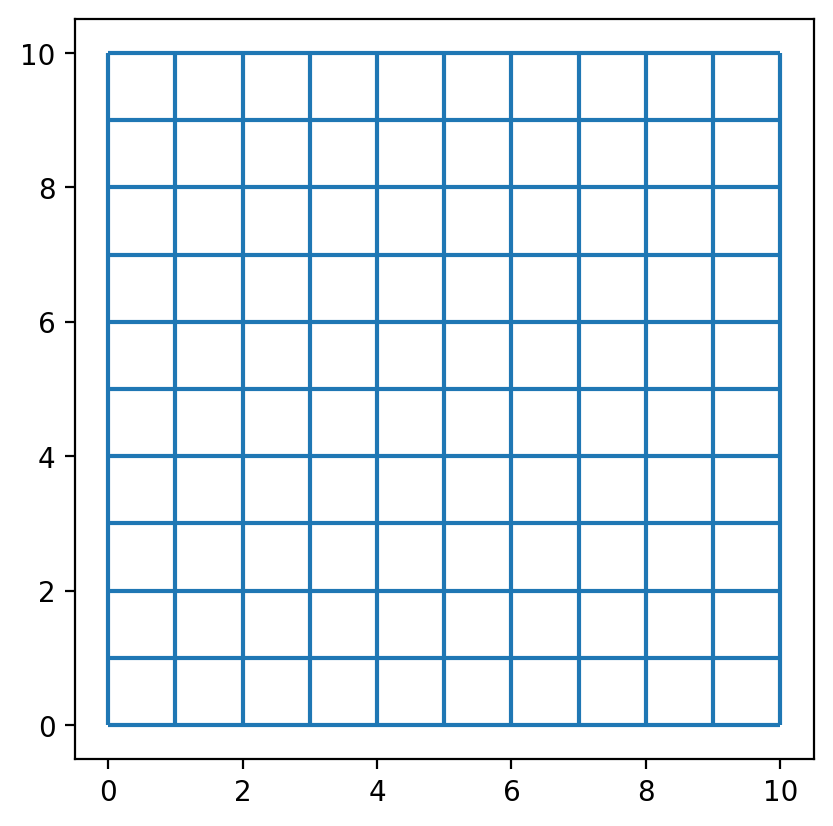

In [7]:
streets.plot();

## Simulate points in a network

The `simulated_geo_points` function simulates points near a network. In this case, it uses the 10x10 lattice network created using the `spaghetti` package. Below we use the function defined above and simulate the points near the lattice edges.

In [8]:
client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 10 facility points we can see that the function generates dummy points to an area of 10x10, which is the area created by our lattice created on previous cells.

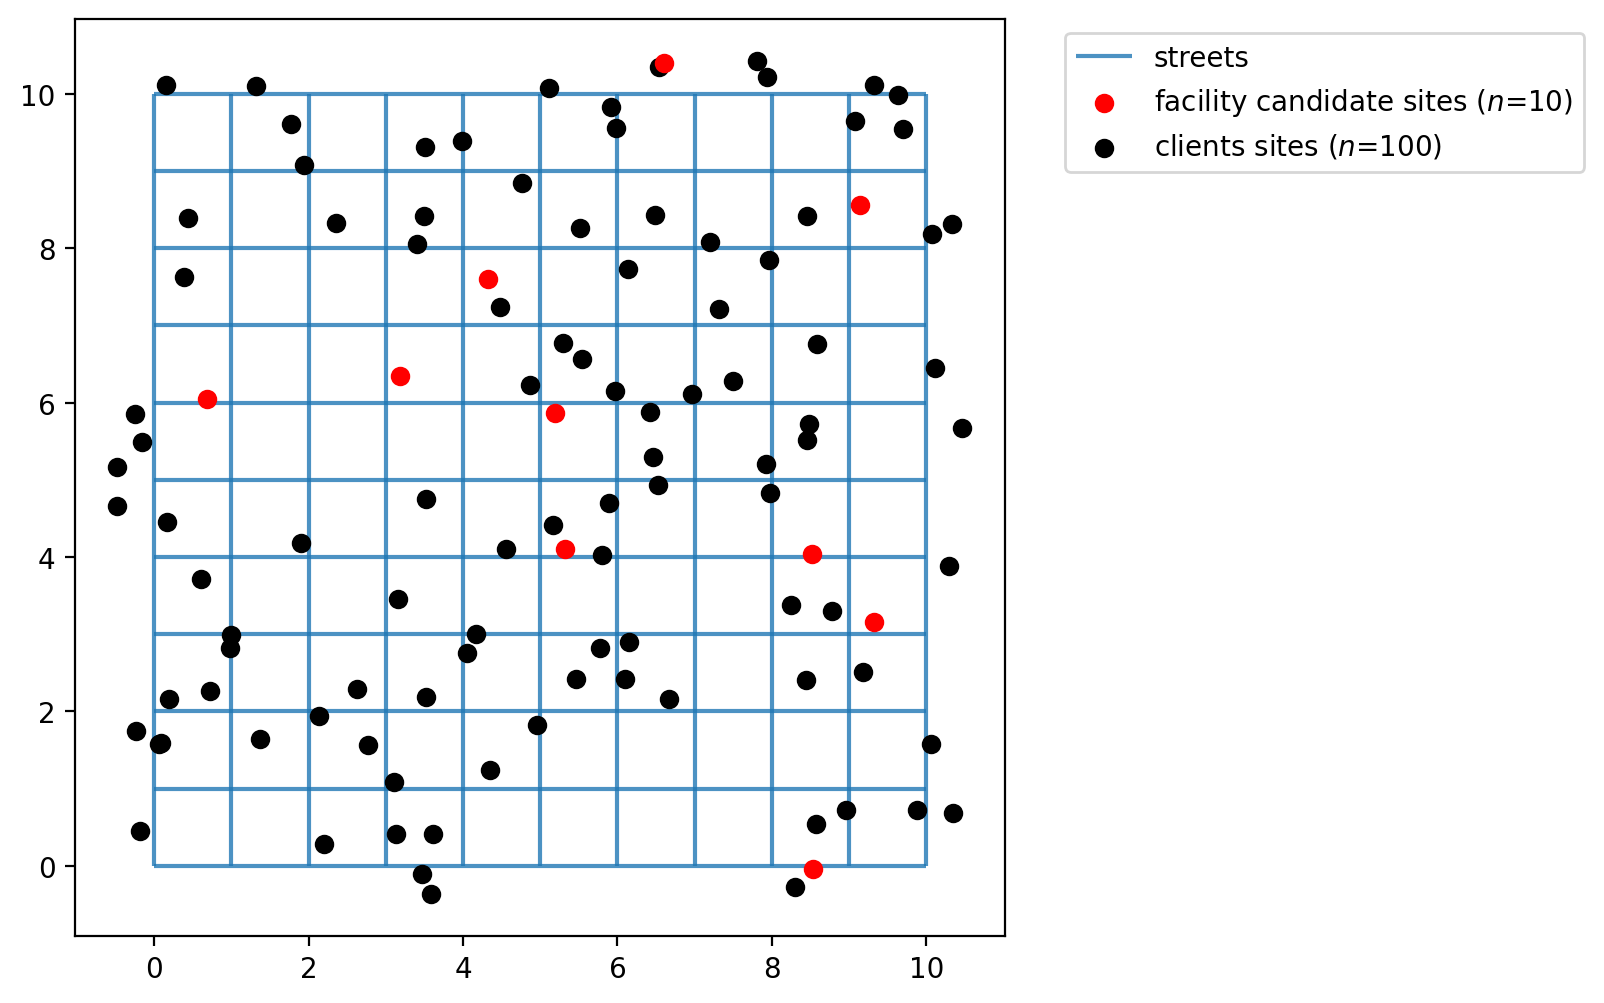

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Assign simulated points network locations

The simulated client and facility points do not ahere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

In our first example we will consider distance along the 10x10 lattice network created above. Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [10]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

Now the plot seems more organized as the points occupy network space. The network is plotted below with the network locations of the facility points and clients points.

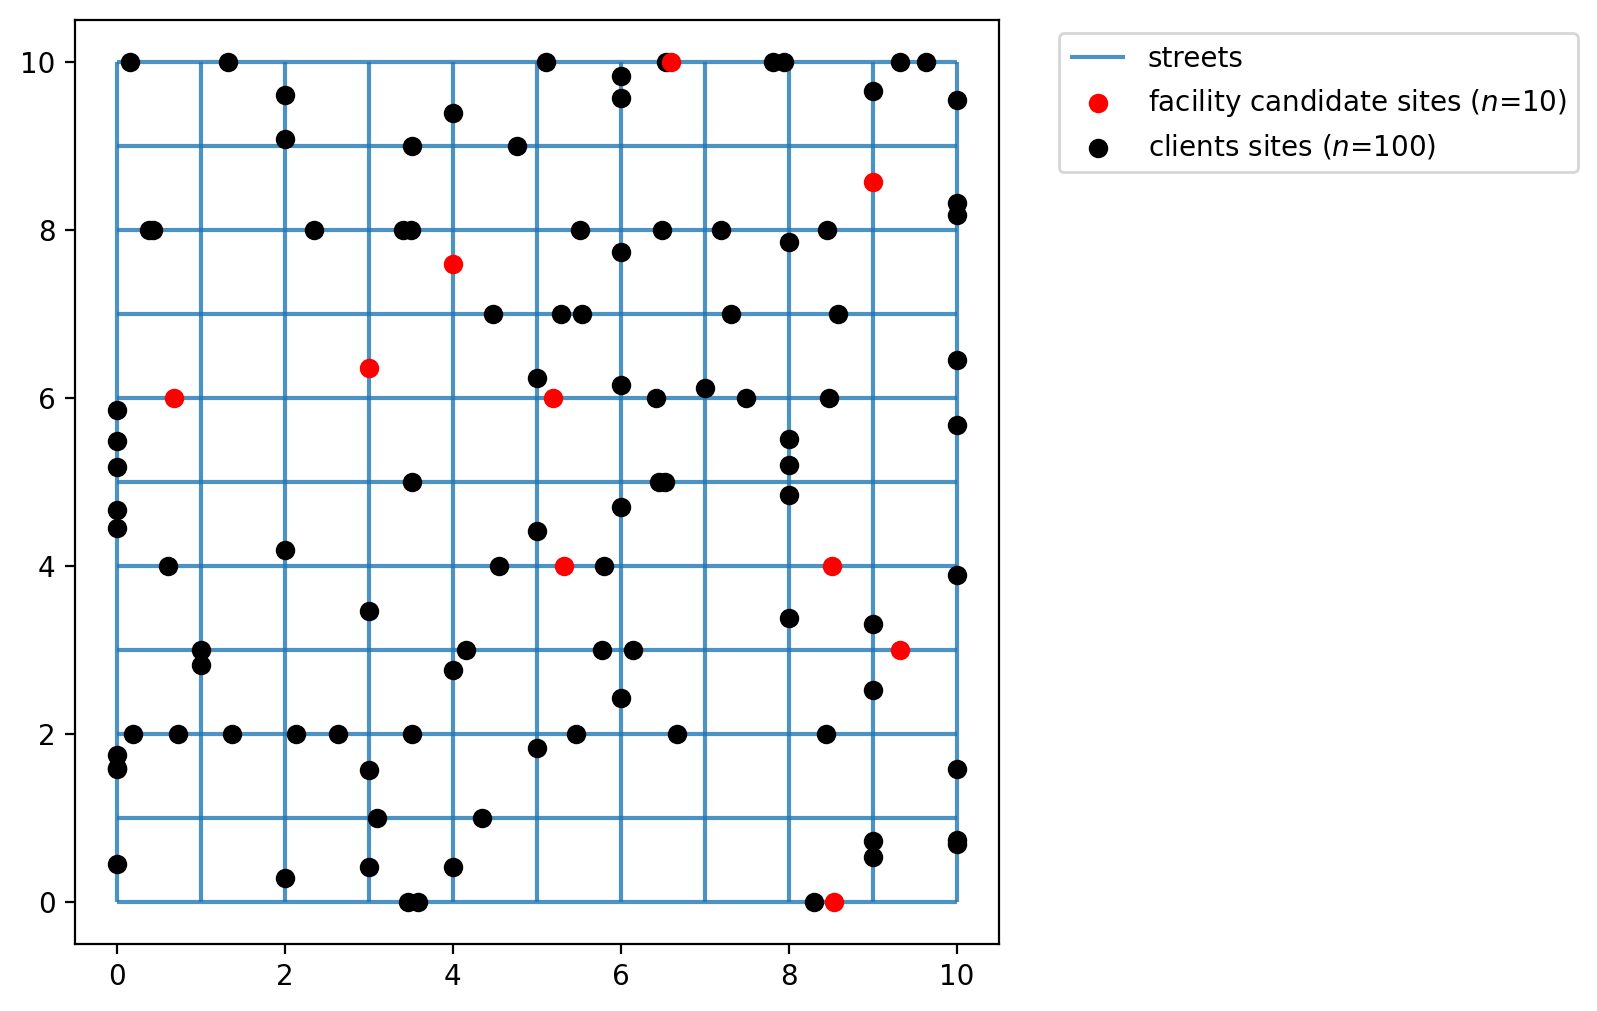

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Calculating the (network distance) cost matrix
Calculate the network distance between clients and facilities.

In [12]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix.shape

(100, 10)

The expected result here is a network distance between clients and facilities points, in our case a 2D 100x10 array.

In [13]:
cost_matrix[:5,:]

array([[13.39951703, 15.61157572,  4.39383189,  8.40604635,  3.73034161,
         3.4833522 ,  6.2764559 ,  5.52085069, 11.59649553,  7.51670161],
       [13.92618165, 16.13824034,  4.92049651,  8.93271097,  4.25700623,
         4.01001682,  6.80312052,  4.99418607, 12.12316015,  8.04336623],
       [ 7.55064416,  9.76270285,  4.54495901,  2.55717348,  2.57689625,
         2.36552068,  0.42758302,  5.36972356,  5.74762266,  6.33217127],
       [ 3.52405953,  5.73611822,  8.11317865,  3.87460688,  6.14511589,
         6.3921053 ,  3.5990016 ,  6.19849608,  1.72103803,  4.35875589],
       [ 7.75652815,  7.09845387,  6.75084301,  4.76305747,  4.78278024,
         7.02976965,  6.63346702, 12.03397254,  7.95350665, 12.99642024]])

In [14]:
cost_matrix[-5:,:]

array([[ 4.82677859,  7.03883728,  6.8104596 ,  4.16669209,  4.84239683,
         5.08938625,  2.29628254,  4.89577702,  3.02375709,  4.06667068],
       [ 6.47650911,  8.6885678 ,  5.47082397,  2.82705646,  3.5027612 ,
         3.43965572,  0.95664692,  4.44385861,  4.67348761,  5.40630631],
       [10.9188216 , 13.13088029,  4.71841659,  5.92535092,  2.05492631,
         1.00265676,  3.79576046,  5.19626599,  9.1158001 ,  6.15871369],
       [ 3.17082521,  5.3828839 ,  8.46641298,  1.82264547,  6.49835021,
         6.74533963,  3.95223592,  7.74954251,  3.36780371,  8.4107173 ],
       [10.03753584,  6.81744618,  7.0318507 ,  7.04406516,  7.06378793,
         9.31077734,  8.91447471, 14.31498023, 10.23451434, 15.27742793]])

With ``PCenter.from_cost_matrix`` we model the $p$-center problem to minimize the maximum cost between any client and any facility while siting $p$ facilities, 3 in our case, and ensuring that each client is assigned to one, and only one, facility. We use the network distance matrix calculated above (in generic 'distance units') to model cost.

In [15]:
pcenter_from_cm = PCenter.from_cost_matrix(
    cost_matrix, p_facilities=P_FACILITIES, name="p-center-network-distance"
)

The expected result is a solved instance of `PCenter`.

In [16]:
pcenter_from_cm = pcenter_from_cm.solve(solver)
pcenter_from_cm

What is the minimized maximum?

In [17]:
pcp_obj = round(pcenter_from_cm.problem.objective.value(), 3)
print(
    f"A single largest minimized maximum distance of {pcp_obj} units is "
    f"observed between a client and selected candidate facility."
)

A single largest minimized maximum distance of 6.836 units is observed between a client and selected candidate facility.


Define the decision variable names used for mapping later.

In [18]:
facility_points["dv"] = pcenter_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (9.32146 3.15178),y0
1,POINT (8.53352 -0.04134),y1
2,POINT (0.68422 6.04557),y2
3,POINT (5.32799 4.10688),y3
4,POINT (3.18949 6.34771),y4
5,POINT (4.31956 7.59470),y5
6,POINT (5.19840 5.86744),y6
7,POINT (6.59891 10.39247),y7
8,POINT (8.51844 4.04521),y8
9,POINT (9.13894 8.56135),y9


## Calculating euclidean distance from a `GeoDataFrame`

With ``PCenter.from_cost_matrix`` we model the $p$-center problem to minimize the maximum cost between any client and any facility while siting $p$ facilities, 3 in our case, and ensuring that each client is assigned to one, and only one, facility. Here we use geodataframes to calculate a euclidean distance cost matrix.

Next we will solve the $p$-center problem considering all 10 candidate locations for potential selection.

In [19]:
distance_metric = "euclidean"
pcenter_from_gdf = PCenter.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    p_facilities=P_FACILITIES,
    distance_metric=distance_metric,
    name=f"p-center-{distance_metric}-distance"
)

In [20]:
pcenter_from_gdf = pcenter_from_gdf.solve(solver)
pcp_obj = round(pcenter_from_gdf.problem.objective.value(), 3)
print(
    f"A single largest minimized maximum distance of {pcp_obj} units is "
    f"observed between a client and selected candidate facility."
)

A single largest minimized maximum distance of 5.73 units is observed between a client and selected candidate facility.


However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_0$ and $y_1$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

In [21]:
facility_points["predefined_loc"] = 0
facility_points.loc[(0, 1), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

,geometry,dv,predefined_loc
0,POINT (9.32146 3.15178),y0,1
1,POINT (8.53352 -0.04134),y1,1
2,POINT (0.68422 6.04557),y2,0
3,POINT (5.32799 4.10688),y3,0
4,POINT (3.18949 6.34771),y4,0
5,POINT (4.31956 7.59470),y5,0
6,POINT (5.19840 5.86744),y6,0
7,POINT (6.59891 10.39247),y7,0
8,POINT (8.51844 4.04521),y8,0
9,POINT (9.13894 8.56135),y9,0


In [22]:
distance_metric = "euclidean"
pcenter_from_gdf_pre = PCenter.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    p_facilities=P_FACILITIES,
    predefined_facility_col="predefined_loc",
    distance_metric=distance_metric,
    name=f"p-center-{distance_metric}-distance-predefined"
)

In [23]:
pcenter_from_gdf_pre = pcenter_from_gdf_pre.solve(solver)
pcp_obj = round(pcenter_from_gdf_pre.problem.objective.value(), 3)
print(
    f"A single largest minimized maximum distance of {pcp_obj} units is "
    f"observed between a client and selected candidate facility."
)

A single largest minimized maximum distance of 7.007 units is observed between a client and selected candidate facility.


## Plotting the results

The two cells below describe the plotting of the results. For each method from the `PCenter` class (`.from_cost_matrix()`, `.from_geodataframe()`) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color.

In [24]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [25]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom
    
    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]
    
    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("MCLP"):
            c = "k"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))
    
    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p
    
    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

### P-Center built from cost matrix (network distance)

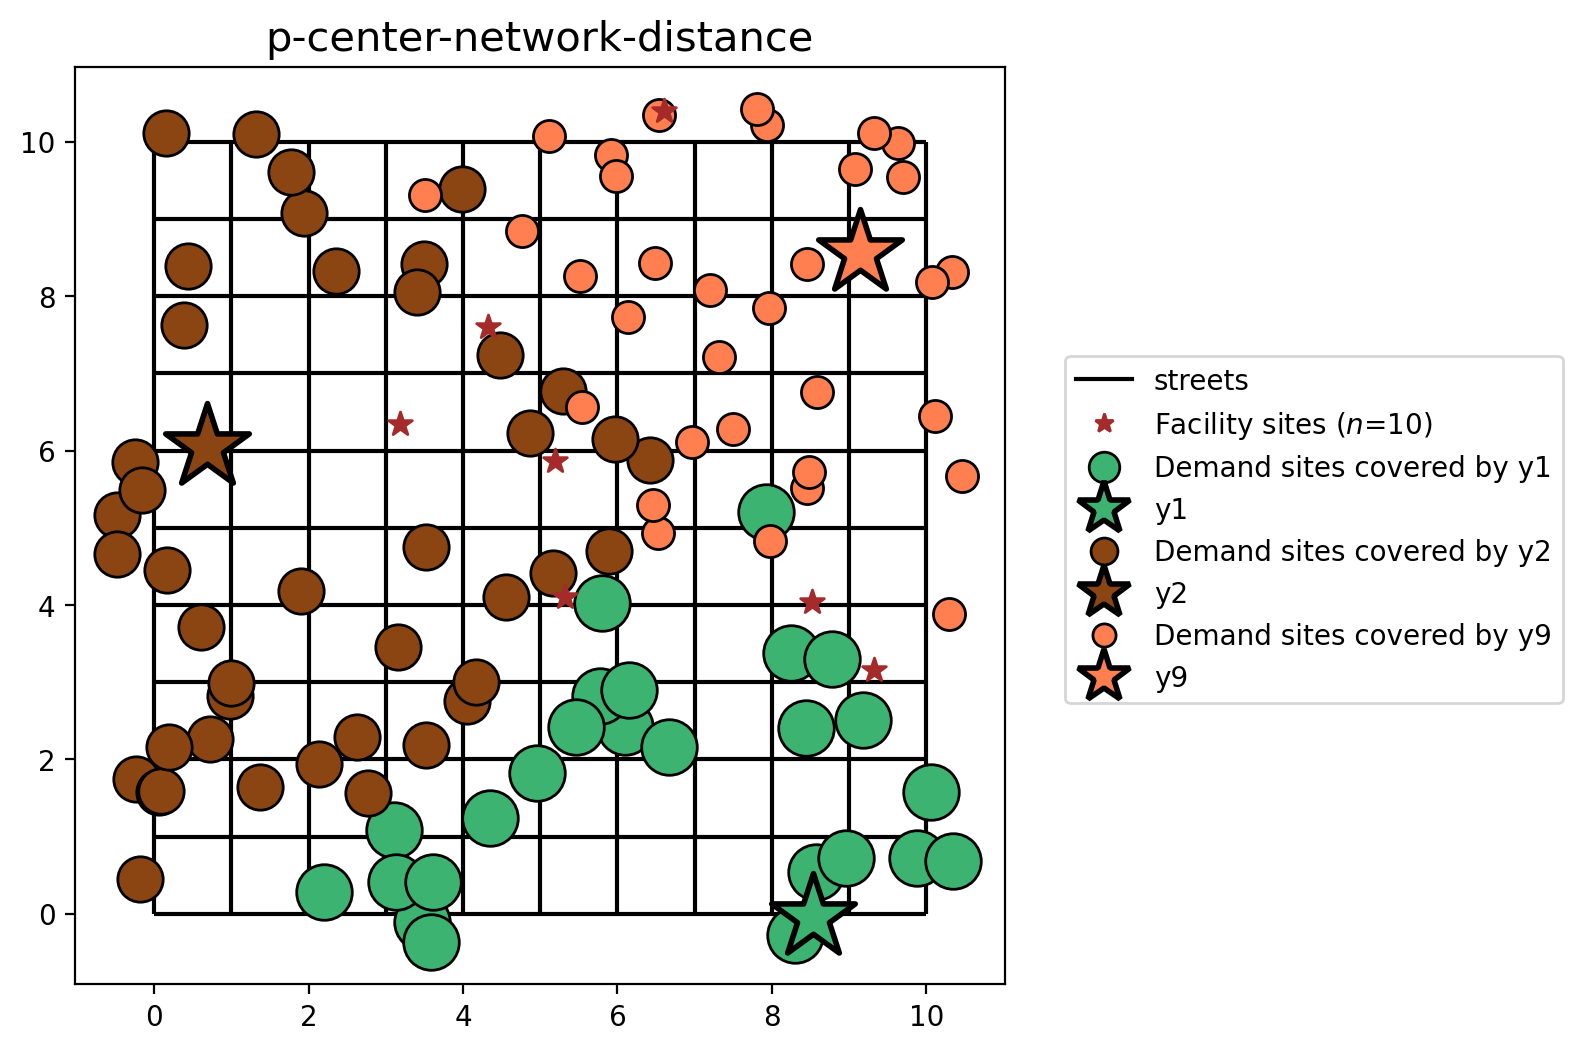

In [26]:
plot_results(pcenter_from_cm, P_FACILITIES, facility_points, clis=client_points)

### P-Center built from geodataframes (euclidean distance)

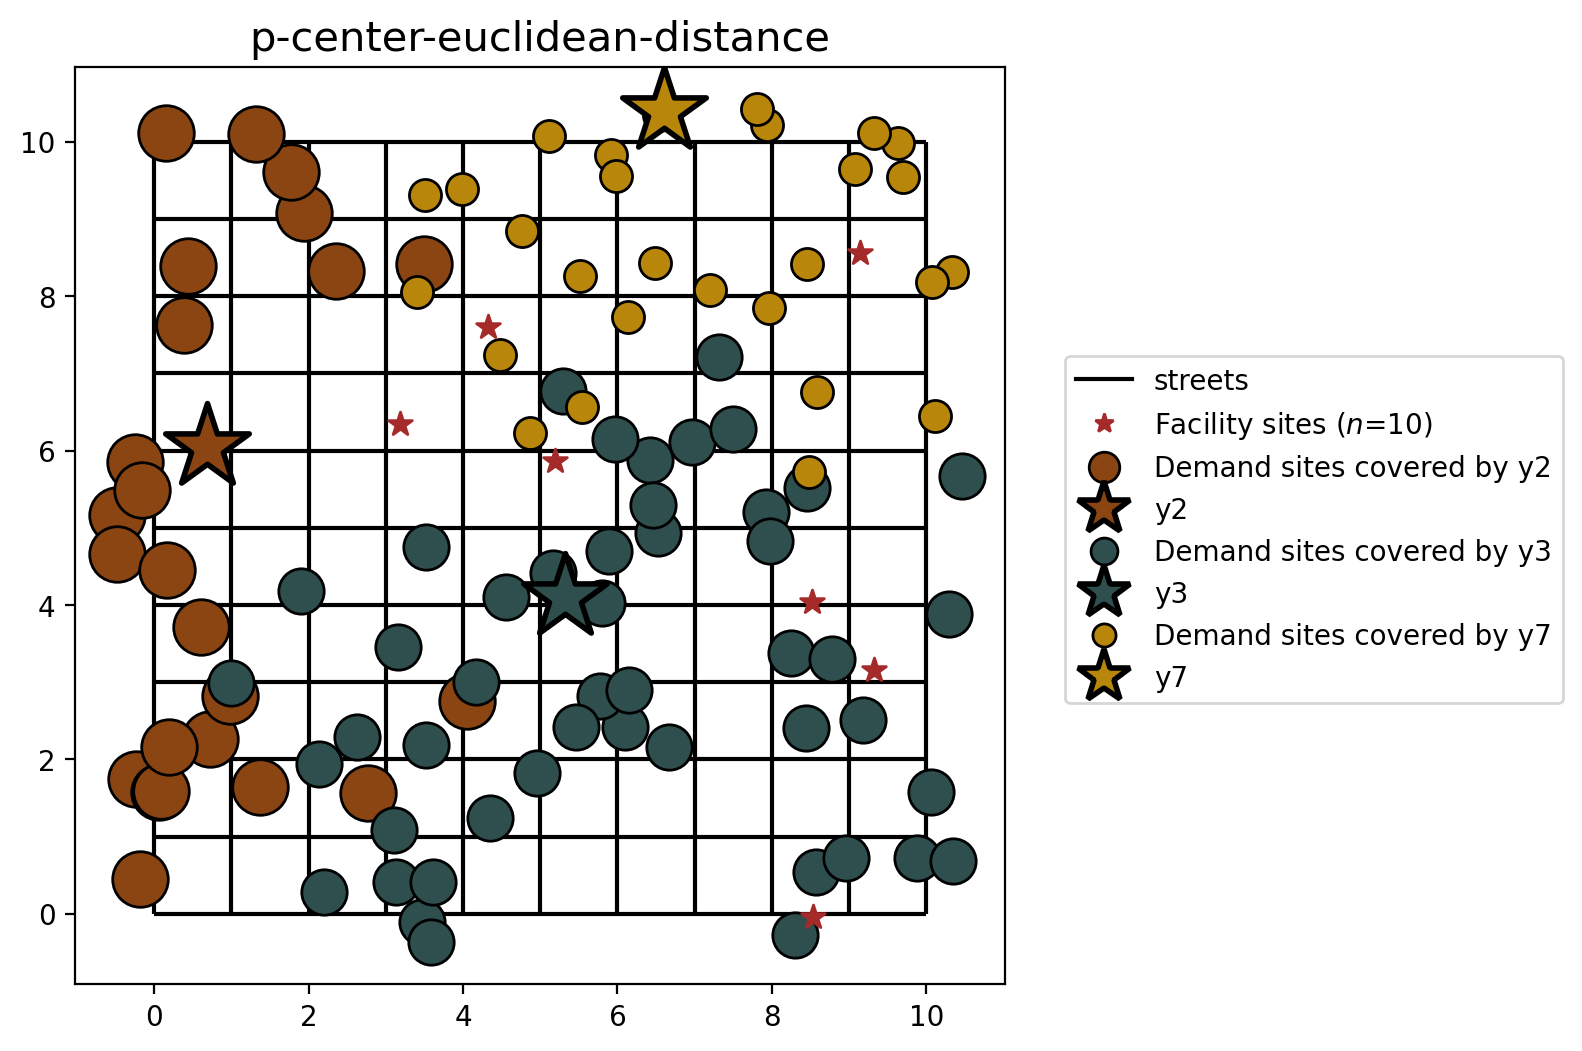

In [27]:
plot_results(pcenter_from_gdf, P_FACILITIES, facility_points, clis=client_points)

You may notice that the model results are similar, yet different. This is expected as the distances between facility and demand points are calculated with different metrics (network vs. euclidean distance).

### P-center with preselected facilities (euclidean distance)

Finally, let's visualize the results of the $p$-center problem when stipulating that facilities $y_0$ and $y_1$ must be included in the final selection.

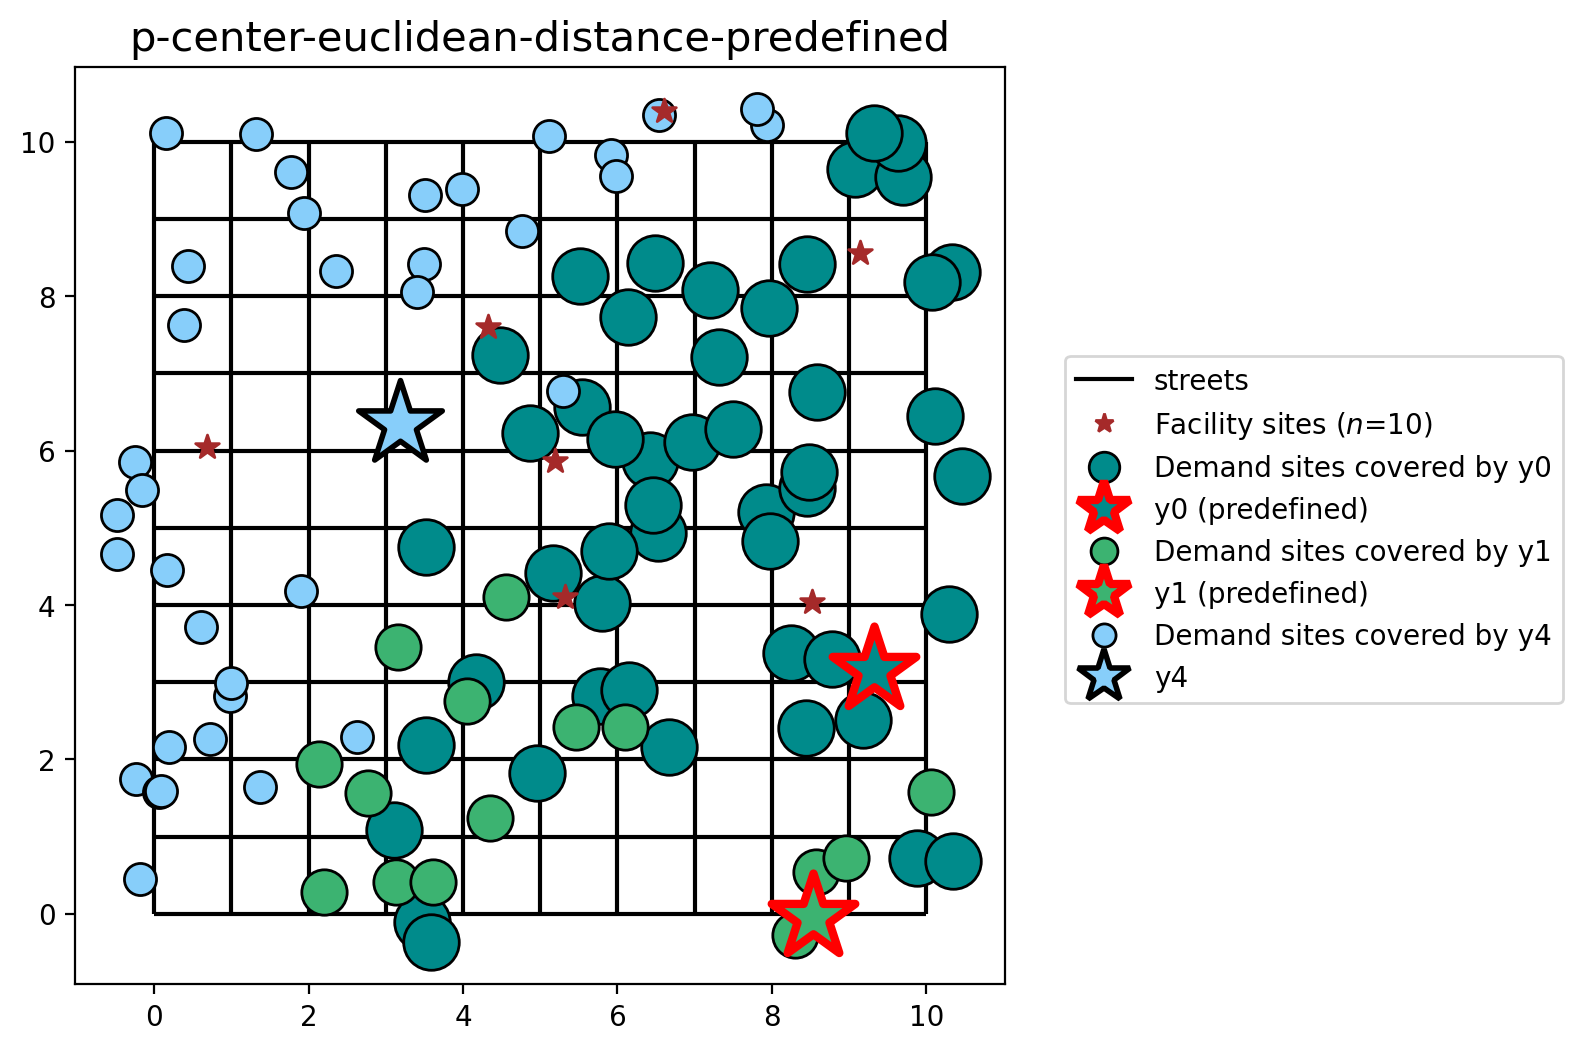

In [28]:
plot_results(pcenter_from_gdf_pre, P_FACILITIES, facility_points, clis=client_points)

Here, the differences is explained by the preselected facilities $y_0$ and $y_1$. So, the $p$-center model chooses the facility $y_4$ to minimize maximum single cost to serve all clients.

-----------------------------------

## Comparing solution from varied metrics

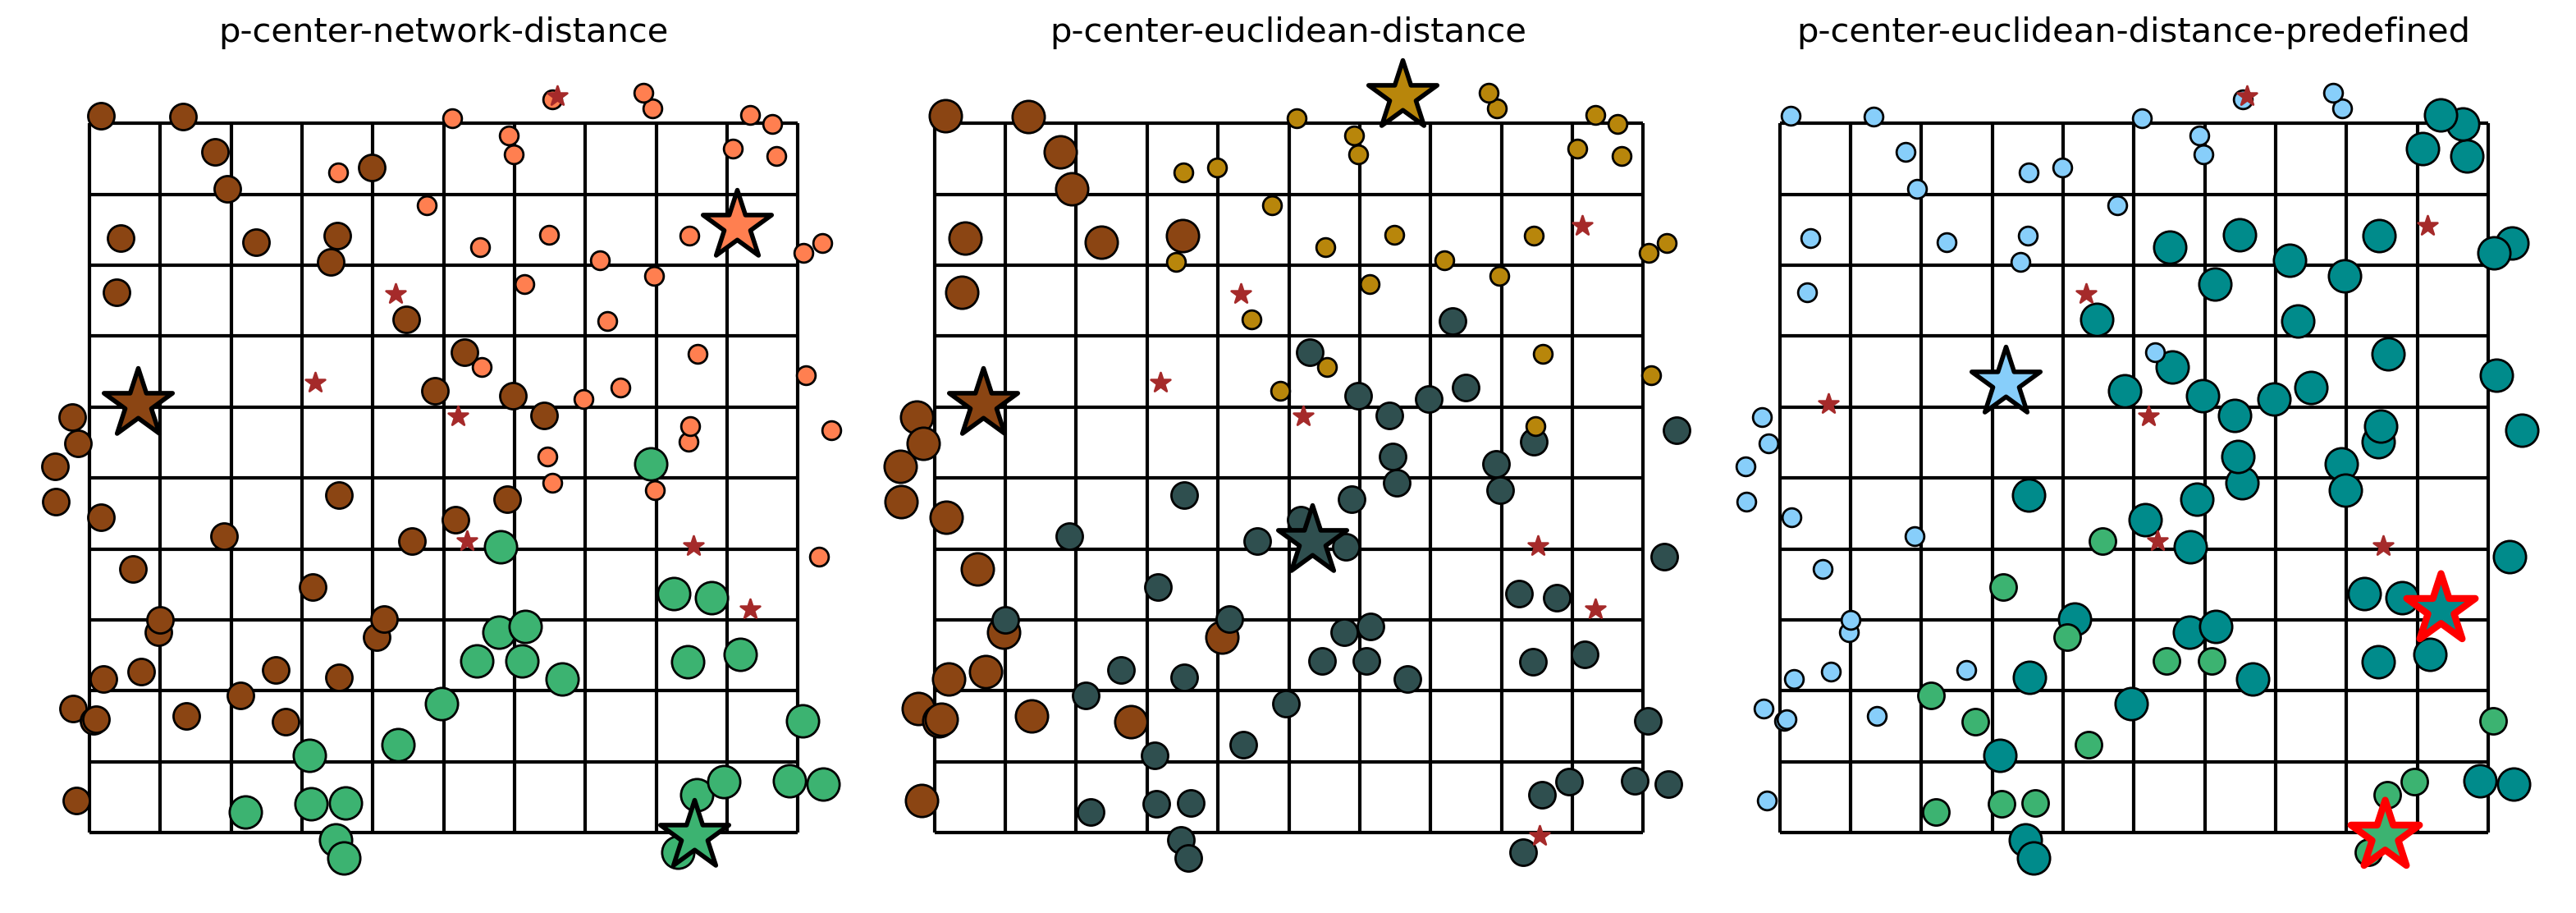

In [29]:
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([pcenter_from_cm, pcenter_from_gdf, pcenter_from_gdf_pre]):
    plot_results(m, P_FACILITIES, facility_points, clis=client_points, ax=axarr[i])

## References

- [Hakimi, S. L. (1965). Optimum Distribution of Switching Centers in a Communication Network and Some Related Graph Theoretic Problems. Operations Research, 13(3), 462–475.](doi:10.1287/opre.13.3.462) 

- [Hakimi, S. L. “Optimum Locations of Switching Centers and the Absolute Centers and Medians of a Graph.” Operations Research, vol. 12, no. 3, 1964, pp. 450–459.](https://doi.org/10.1287/opre.12.3.450)

- [Calik H., Labbé M., Yaman H. (2015) p-Center Problems. In: Laporte G., Nickel S., Saldanha da Gama F. (eds) Location Science. Springer, Cham.](https://doi.org/10.1007/978-3-319-13111-5_4)

- [Daskin, M. S. (2013). Network and Discrete Location: Models, Algorithms, and Applications (2nd ed.). Wiley.](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118537015)
